In [1]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os


from pyspecter.SPECTER import SPECTER
from pyspecter.Observables import Observable
# from pyspecter.SpecialObservables import SpecialObservables

# Utils
from particleloader import load
from rikabplotlib.plot_utils import newplot, hist_with_errors, hist_with_outline, plot_event, stamp


# SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

In [2]:
random_seed = 0
np.random.seed(random_seed)

# CMS Open Sim Parameters
R = 0.5
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 100 # Note that runtime is pad^2, memory is pad^4

dataset = "CMS"
n_samples = 500 * 2 # CMS Open Sim Parameters
R = 0.5
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 10 # Note that runtime is pad^2, memory is pad^4
batch_size = 1 # Number of pairs to process in parallel, can probably be increased.

data_directory = "/n/holyscratch01/iaifi_lab/rikab/top_qcd/top_qcd_0.npz"
this_dir = "/n/home01/rikab/SPECTER_STUDIES"

d = np.load(data_directory)
X = np.array(d["data"])
Y = d["labels"]

qcd = X[Y == 0]
top = X[Y == 1]

dataset = qcd[:500, :pad, :3]

for x in dataset:

        energies = x[:,0]
        etas = x[:,1]
        phis = x[:, 2]

        # translate such that the phi of the hardest particle is 0
        max_phi_index = np.argmax(energies)
        phis = phis - phis[max_phi_index]

        # # # Wrap the phis to be between -pi and pi
        phis = (phis ) % (2 * np.pi)
        phis_above_pi = phis > np.pi
        phis[phis_above_pi] = phis[phis_above_pi] - 2 * np.pi
        phis_below_minus_pi = phis < - np.pi
        phis[phis_below_minus_pi] = phis[phis_below_minus_pi] + 2 * np.pi
        # # phis = (phis ) % (2 * np.pi)

        x[:,0] = energies / np.sum(energies)
        x[:,1] = etas - np.average(etas, weights=energies)
        x[:,2] = phis - np.average(phis, weights=energies)


        # # # Wrap the phis to be between -pi and pi
        phis = x[:,2]
        phis = (phis ) % (2 * np.pi)
        phis_above_pi = phis > np.pi
        phis[phis_above_pi] = phis[phis_above_pi] - 2 * np.pi
        phis_below_minus_pi = phis < - np.pi
        phis[phis_below_minus_pi] = phis[phis_below_minus_pi] + 2 * np.pi
        x[:,2] = phis - np.average(phis, weights=energies)

weights = np.ones(len(dataset))

# Split dataset into 2 halves
dataset1 = dataset[:n_samples//2]
dataset2 = dataset[n_samples//2:]
weights1 = weights[:n_samples//2]
weights2 = weights[n_samples//2:]


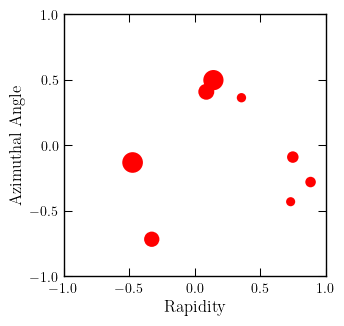

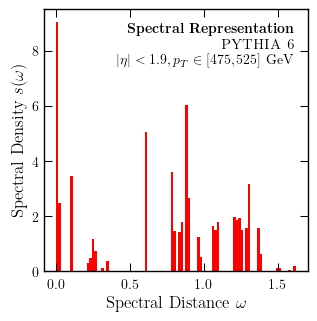

In [3]:
# Figure 1: Detector Representation

fig, ax = newplot("column")
plot_event(ax, dataset1[1], 1)

line_0 = r"Detector Representation"
line_1 = r"$\textsc{PYTHIA 6}$"
line_2 = r"$|\eta| < 1.9, p_T \in [475, 525]$ GeV"
stamp(0.05, 0.925, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2)

# plt.savefig("Plots/detector_representation.pdf", bbox_inches="tight")

# Figure 2: Spectral Representation

spectral_repesentation = compute_spectral_representation(dataset1[1], )
fig, ax = newplot("column")
plt.hist(spectral_repesentation[:,0], bins=100, histtype="stepfilled", weights = spectral_repesentation[:,1], density=True, color="red", label="Spectral Representation")
plt.xlabel(r"Spectral Distance $\omega$")
plt.ylabel(r"Spectral Density $s(\omega)$")

line_0 = r"Spectral Representation"
line_1 = r"$\textsc{PYTHIA 6}$"
line_2 = r"$|\eta| < 1.9, p_T \in [475, 525]$ GeV"
stamp(0.95, 0.925, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"ha" : "right"})

# plt.savefig("Plots/spectral_representation.pdf", bbox_inches="tight")

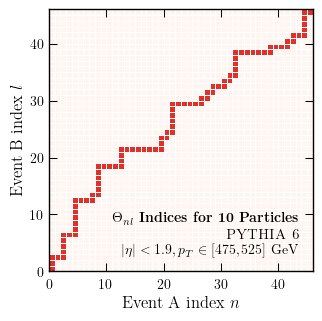

In [11]:
from pyspecter.SpectralEMD_Helper import find_indices, find_indices_jax

spectral_2 = compute_spectral_representation(dataset1[1])
spectral_1 = compute_spectral_representation(dataset1[2])

cumulative_1 = np.cumsum(spectral_1[:,1])
cumulative_2 = np.cumsum(spectral_2[:,1])


indices, mask = find_indices(cumulative_1, cumulative_2)
mask = np.array(mask)
mask[:10] = True # For plotting only, the 0's dont matter in the computation

# If any of the indices are 46, remove

# Make matrix of indices: (i,j) pixel is colored only if it is in indices
indices_matrix = np.zeros((len(cumulative_1), len(cumulative_2)))
indices_matrix[indices[mask,0], indices[mask,1]] = 1
indices_matrix = indices_matrix.T


# Figure 3: 2D histogram where the (i,j) pixel is colored only if it is in indices
fig, ax = newplot("column")


# colors so that if the matrix is 1, it is bright red, if it is 0, it is white



plt.pcolormesh(indices_matrix, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)
# plt.xlim(0.5, len(cumulative_2))
# plt.ylim(0.5, len(cumulative_1))

plt.xlabel(r"Event A index $n$")
plt.ylabel(r"Event B index $l$")


line_0 = r"$\Theta_{nl}$ Indices for 10 Particles"
line_1 = r"$\textsc{PYTHIA 6}$"
line_2 = r"$|\eta| < 1.9, p_T \in [475, 525]$ GeV"
stamp(0.95, 0.2, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"ha" : "right"})

print()

# Major ticks
size = len(cumulative_2) 
# ax.set_xticks(np.arange(0, size, 10))
# ax.set_yticks(np.arange(0, size, 10))

# # # Labels for major ticks
# ax.set_xticklabels(np.arange(1, size + 1, 10))
# ax.set_yticklabels(np.arange(1, size + 1, 10))

# # Minor ticks
# ax.set_xticks(np.arange(0, size + 0, 1), minor=True)
# ax.set_yticks(np.arange(0, size + 0, 1), minor=True)

# # Gridlines based on minor ticks
# ax.grid(which='minor', color='blue', linestyle='-', linewidth=0.5)
# ax.grid(which='major', color='blue', linestyle='-', linewidth=0.5)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)

# plt.savefig("Plots/theta_indices.pdf", bbox_inches="tight")



[[ 0  2]
 [ 1  2]
 [ 2  6]
 [ 3  6]
 [ 4 12]
 [ 5 12]
 [ 6 12]
 [ 7 13]
 [ 8 18]
 [ 9 18]
 [10 18]
 [11 18]
 [12 21]
 [13 21]
 [14 21]
 [15 21]
 [16 21]
 [17 21]
 [18 21]
 [19 23]
 [20 24]
 [21 29]
 [22 29]
 [23 29]
 [24 29]
 [25 29]
 [26 30]
 [27 31]
 [28 32]
 [29 32]
 [30 33]
 [31 34]
 [32 38]
 [33 38]
 [34 38]
 [35 38]
 [36 38]
 [37 38]
 [38 39]
 [39 39]
 [40 39]
 [41 40]
 [42 41]
 [43 41]
 [44 45]
 [45 45]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]]


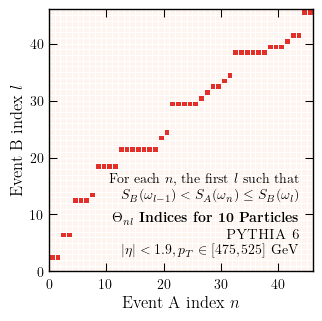

In [16]:
import jax.numpy as jnp

X, Y = cumulative_1, cumulative_2

j_indices = jnp.searchsorted(Y, X, side = 'left')
i_indices = jnp.searchsorted(X, Y, side = 'left')

# i indices
pairs = jnp.zeros((X.shape[0] + Y.shape[0], 2), dtype=int)
pairs = pairs.at[0:X.shape[0], 0].set(jnp.arange(X.shape[0]))
pairs = pairs.at[0:X.shape[0], 1].set(j_indices)
print(pairs)

# pairs = pairs.at[X.shape[0]:X.shape[0] + Y.shape[0], 0].set(i_indices)
# pairs = pairs.at[X.shape[0]:X.shape[0] + Y.shape[0], 1].set(jnp.arange(Y.shape[0]))

indices_matrix_i = np.zeros((len(cumulative_1), len(cumulative_2)))
indices_matrix_i[pairs[:X.shape[0],0], pairs[:X.shape[0],1]] = 1
indices_matrix_i = indices_matrix_i.T

fig, ax_i = newplot("column")
plt.pcolormesh(indices_matrix_i, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)
# plt.xlim(0, len(cumulative_2))
# plt.ylim(0, len(cumulative_1))

plt.xlabel(r"Event A index $n$")
plt.ylabel(r"Event B index $l$")


text_0 = r"For each $n$, the first $l$ such that"
text_1 = r"$S_B(\omega_{l-1}) < S_A(\omega_n) \leq S_B(\omega_l)$"
stamp(0.95, 0.35, ax_i, line_0 = text_0, line_1 = text_1, textops_update={"ha" : "right"}, boldfirst=False)

line_0 = r"$\Theta_{nl}$ Indices for 10 Particles"
line_1 = r"$\textsc{PYTHIA 6}$"
line_2 = r"$|\eta| < 1.9, p_T \in [475, 525]$ GeV"
stamp(0.95, 0.2, ax_i, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"ha" : "right"})

# plt.savefig("Plots/theta_indices_j.pdf", bbox_inches="tight")


[ 0  0  2  2  2  2  4  4  4  4  4  4  7  8  8  8  8  8 12 12 12 19 19 20
 21 21 21 21 21 26 27 28 30 31 32 32 32 32 38 41 42 44 44 44 44 46]
[ 2  2  6  6 12 12 12 13 18 18 18 18 21 21 21 21 21 21 21 23 24 29 29 29
 29 29 30 31 32 32 33 34 38 38 38 38 38 38 39 39 39 40 41 41 45 45]
[[ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 4  6]
 [ 4  7]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 4 11]
 [ 7 12]
 [ 8 13]
 [ 8 14]
 [ 8 15]
 [ 8 16]
 [ 8 17]
 [12 18]
 [12 19]
 [12 20]
 [19 21]
 [19 22]
 [20 23]
 [21 24]
 [21 25]
 [21 26]
 [21 27]
 [21 28]
 [26 29]
 [27 30]
 [28 31]
 [30 32]
 [31 33

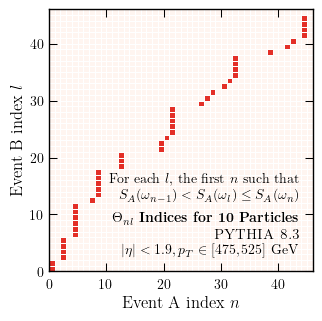

In [17]:
import jax.numpy as jnp

X, Y = cumulative_1, cumulative_2

j_indices = jnp.searchsorted(Y, X, side = 'left')
i_indices = jnp.searchsorted(X, Y, side = 'left')

print(i_indices)
print(j_indices)

# i indices
pairs = jnp.zeros((X.shape[0] + Y.shape[0], 2), dtype=int)
# pairs = pairs.at[0:X.shape[0], 0].set(jnp.arange(X.shape[0]))
# pairs = pairs.at[0:X.shape[0], 1].set(j_indices)
pairs = pairs.at[X.shape[0]:X.shape[0] + Y.shape[0], 0].set(i_indices)
pairs = pairs.at[X.shape[0]:X.shape[0] + Y.shape[0], 1].set(jnp.arange(Y.shape[0]))
mask = jnp.logical_and(pairs[:,0] < X.shape[0], pairs[:,1] < Y.shape[0])


print(pairs)

indices_matrix_j = np.zeros((len(cumulative_1), len(cumulative_2)))
indices_matrix_j[pairs[mask,0], pairs[mask,1]] = 1
indices_matrix_j = indices_matrix_j.T

fig, ax_j = newplot("column")
plt.pcolormesh(indices_matrix_j, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)


plt.xlabel(r"Event A index $n$")
plt.ylabel(r"Event B index $l$")


text_0 = r"For each $l$, the first $n$ such that"
text_1 = r"$S_A(\omega_{n-1}) < S_A(\omega_l) \leq S_A(\omega_n)$"
stamp(0.95, 0.35, ax_j, line_0 = text_0, line_1 = text_1, textops_update={"ha" : "right"}, boldfirst=False)

line_0 = r"$\Theta_{nl}$ Indices for 10 Particles"
line_1 = r"$\textsc{PYTHIA 8.3}$"
line_2 = r"$|\eta| < 1.9, p_T \in [475, 525]$ GeV"
stamp(0.95, 0.2, ax_j, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"ha" : "right"})

# plt.savefig("Plots/theta_indices_i.pdf", bbox_inches="tight")


FileNotFoundError: [Errno 2] No such file or directory: 'Plots/theta_indices_all.pdf'

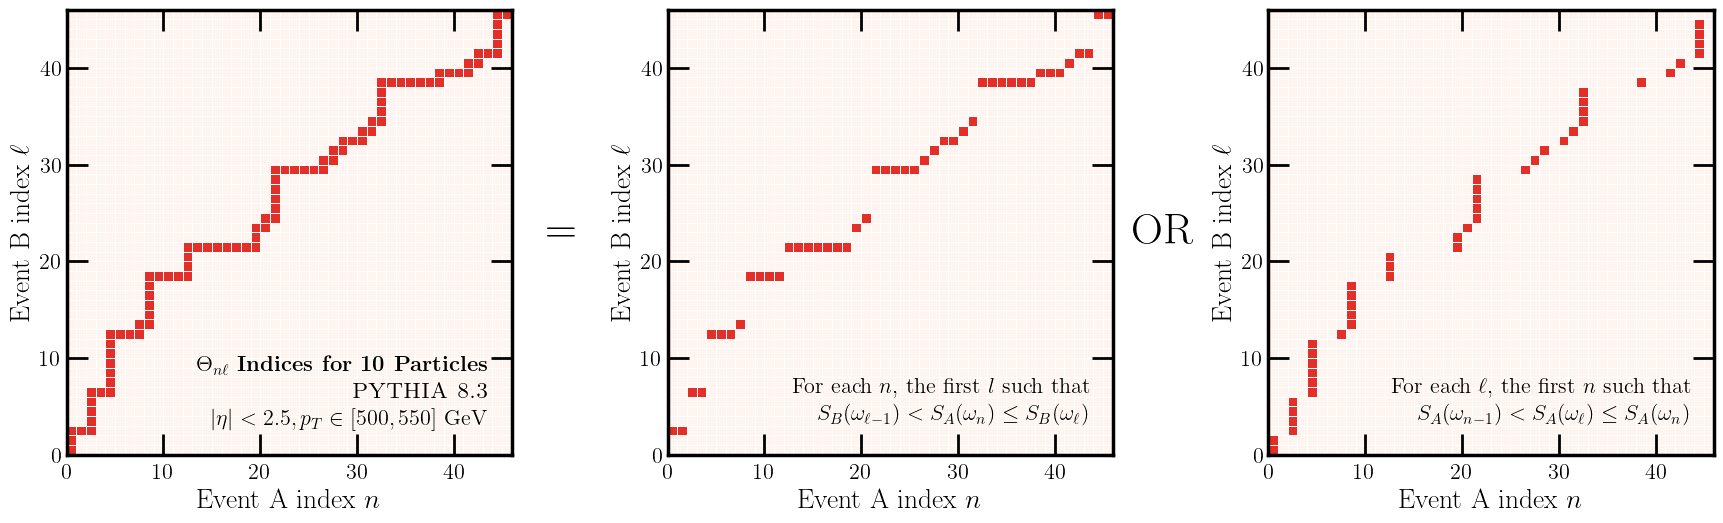

In [19]:
# Load the previous 3 plots (PDF) and make a 3x1 plot in a row

fig, ax = newplot("full", subplot_array=(1,3), aspect_ratio=1/3)

ax[0].pcolormesh(indices_matrix, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)
ax[0].set_xlabel(r"Event A index $n$")
ax[0].set_ylabel(r"Event B index $\ell$")
ax[0].set_aspect("equal")

ax[1].pcolormesh(indices_matrix_i, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)
ax[1].set_xlabel(r"Event A index $n$")
ax[1].set_ylabel(r"Event B index $\ell$")
ax[1].set_aspect("equal")

ax[2].pcolormesh(indices_matrix_j, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)
ax[2].set_xlabel(r"Event A index $n$")
ax[2].set_ylabel(r"Event B index $\ell$")
ax[2].set_aspect("equal")


# Increase space between subplots
plt.subplots_adjust(wspace=0.35)


# Text 
line_0 = r"$\Theta_{n\ell}$ Indices for 10 Particles"
line_1 = r"$\textsc{PYTHIA 8.3}$"
line_2 = r"$|\eta| < 2.5, p_T \in [500, 550]$ GeV"
stamp(0.95, 0.2, ax[0], line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"ha" : "right"})


text_0 = r"For each $n$, the first $\ell$ such that"
text_1 = r"$S_B(\omega_{\ell-1}) < S_A(\omega_n) \leq S_B(\omega_\ell)$"
stamp(0.95, 0.15, ax[1], line_0 = text_0, line_1 = text_1, textops_update={"ha" : "right"}, boldfirst=False)

text_0 = r"For each $\ell$, the first $n$ such that"
text_1 = r"$S_A(\omega_{n-1}) < S_A(\omega_\ell) \leq S_A(\omega_n)$"
stamp(0.95, 0.15, ax[2], line_0 = text_0, line_1 = text_1, textops_update={"ha" : "right"}, boldfirst=False)

# Between subplots 0 and 1, add text
text_0 = r"For each $n$, the first $\ell$ such that"
text_1 = r"$S_B(\omega_{\ell-1}) < S_A(\omega_n) \leq S_B(\omega_\ell)$"
stamp(1.15, 0.5, ax[0], line_0 = "=", textops_update={"ha" : "right", "fontsize" : 32}, boldfirst=False)
stamp(1.185, 0.5, ax[1], line_0 = "OR", textops_update={"ha" : "right", "fontsize" : 32}, boldfirst=False)

plt.savefig("theta_indices_all.pdf", bbox_inches="tight")
